<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Zabour, Sofia
* Salah, Djamel
* Wane, Ismael

# Présentation du challenge

## La question principale de ce challenge est :

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ?
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital

Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce projet est de travailler sur un challenge de prédiction de la mortalité.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour la qualité de la présentation orale

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn`

In [68]:
!pip install xgboost

In [69]:
!pip install imbalanced-learn

In [70]:
import platform
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway, pearsonr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import imblearn
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn import decomposition
import imblearn.pipeline
import imblearn.over_sampling
import warnings

from sklearn.metrics import precision_score, recall_score


In [71]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

sns.set_style("darkgrid")
sns.set_context("notebook")

print(pd.__version__)       # 2.0.0
print(sklearn.__version__)  # 1.2.2

2.0.2
1.2.2


## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

L'objectif du projet est d'utiliser des modèles d'apprentissage supervisé avec la library scikitlearn et des techniques de traitement de données pour classifier avec le plus d'accuracy possible si un patient est mort ou pas pendant son séjour à l'hopital. On va fit nos modeles avec un training dataset de 80000 patients déjà labeled et tune les hyperparametres pour trouver le modèle le plus adapté puis l'utiliser pour predire les labels de données jamais vues auparavant.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

Il faut comprendre que la distribution des patients entre les deux labels est très inégal, dans le training dataset environ 3% des patients meurt. Si on utilise la métrique accuracy il suffit de donner un modèle qui dit que le patient va pas mourir pour avoir 97% de accuracy ce qui n'est pas du tout un modèle prédictif correct (On peut pas prédire quel patients vont mourir). À cause de ce probleme, on utilise balanced accuracy qui tient en compte de la distribution inégal parmis les deux classes.

## 2. Chargement des données

In [72]:
DATA = Path(
    "/data"
).expanduser()

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [73]:
features = pd.read_csv(
     "data/mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    "data/mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
     "data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        "data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [74]:
print(x_df.shape)
x_df.head(3)

(79999, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codabench (les modalités pour la téléversion seront précisées prochainement sur la page du cours eCampus）et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [75]:
# Load test set
x_test_df = pd.read_csv(
    "data/mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

print(x_test_df.shape)
x_test_df.head(3)

(20001, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


## 3. Analyse exploratoire

#### Types des variables

In [76]:
types = pd.read_csv( "data/mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

0
Numerical      226
Binary         107
Categorical      8
Name: count, dtype: int64

#### Distribution de la variable cible

In [77]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

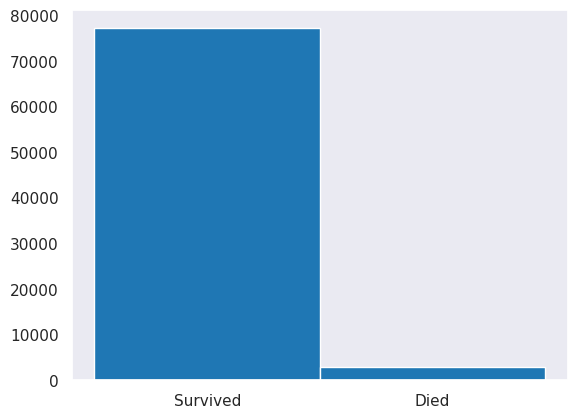

In [78]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

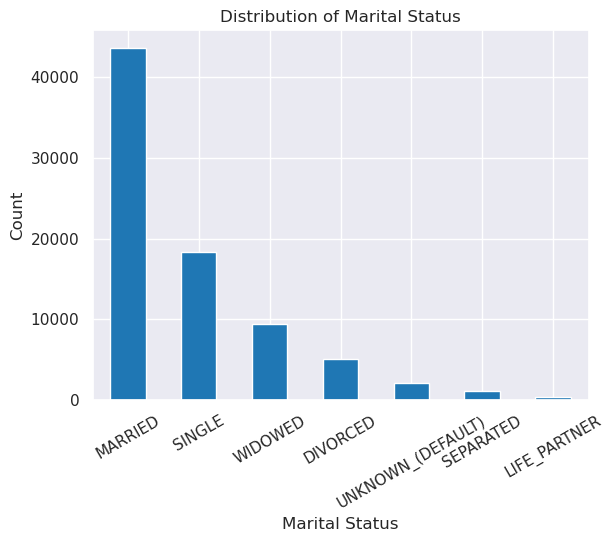

In [79]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Distribution of Marital Status")
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>

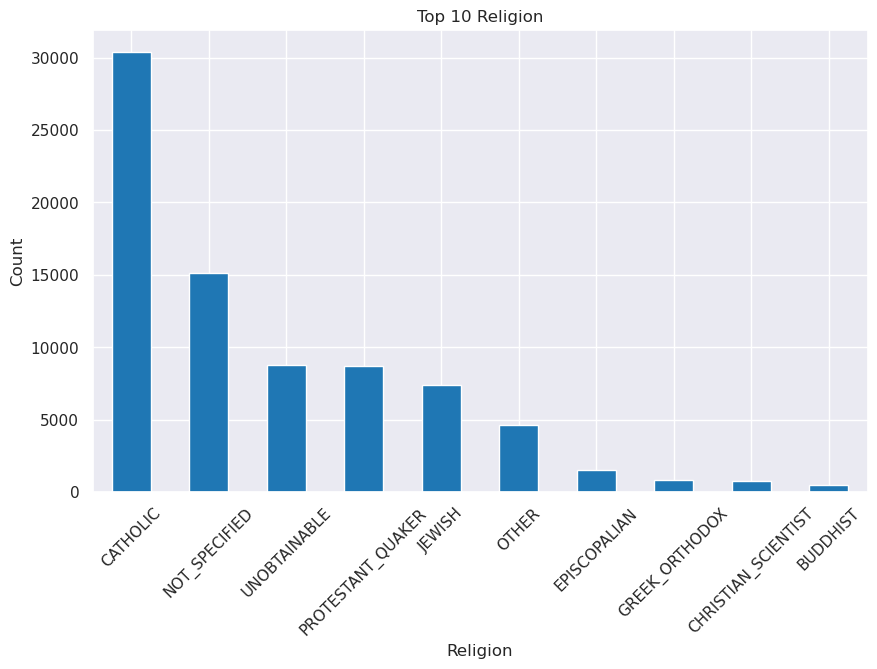

In [80]:
# Sélectionner les 10 catégories les plus fréquentes
top_10_ethnicities = x_df["RELIGION"].value_counts().nlargest(10)

# Créer le graphique à barres pour les 10 catégories les plus fréquentes
plt.figure(figsize=(10, 6))
top_10_ethnicities.plot(kind='bar', rot=45)
plt.xlabel('Religion')
plt.ylabel('Count')
plt.title('Top 10 Religion')
plt.show()


#### Corrélations

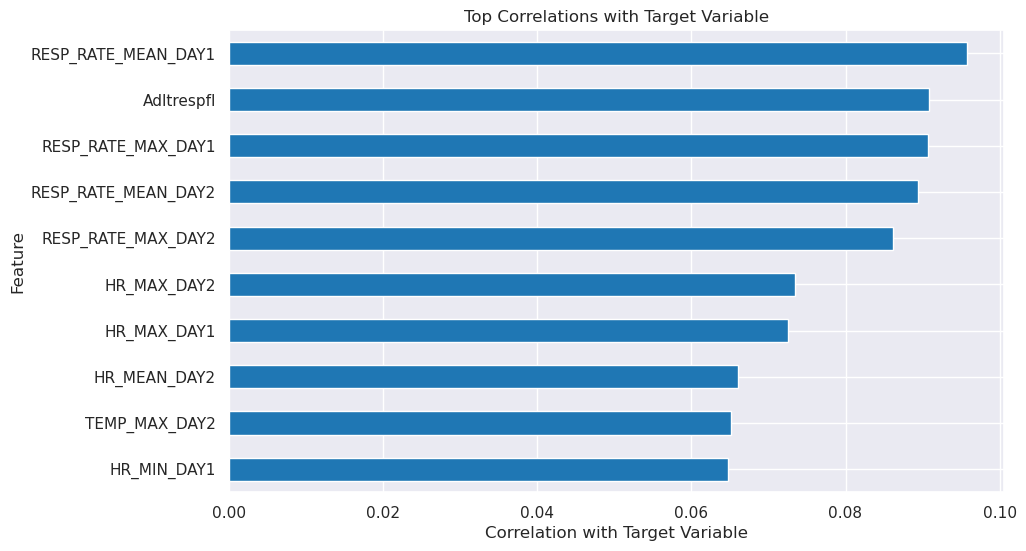

In [81]:
# Sélectionner uniquement les colonnes numériques pour le calcul des corrélations
numeric_columns = x_df.select_dtypes(include=['int64', 'float64']).columns
correlations = x_df[numeric_columns].corrwith(ys)

# Sélection des variables les plus corrélées (positivement ou négativement)
top_correlations = correlations.abs().nlargest(10)

# Création du graphique à barres horizontales
plt.figure(figsize=(10, 6))
top_correlations.plot(kind='barh')
plt.xlabel('Correlation with Target Variable')
plt.ylabel('Feature')
plt.title('Top Correlations with Target Variable')
plt.gca().invert_yaxis()  # Inversion de l'axe y pour afficher les variables les plus corrélées en haut
plt.show()


Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

#### Autres graphiques ou résultats d'une analyse exploratoire

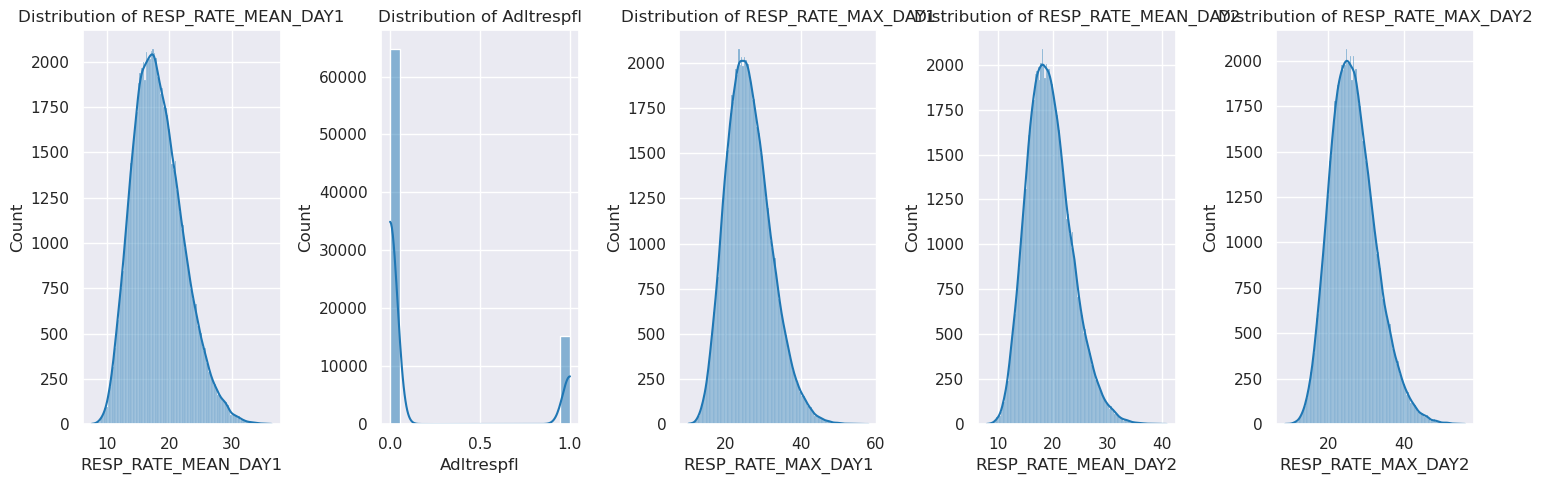

In [82]:
plt.figure(figsize=(15, 5))
top_5_correlations = top_correlations.head(5)
for i, feature in enumerate(top_5_correlations.index):
    plt.subplot(1, 5, i+1)
    sns.histplot(x_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
plt.show()


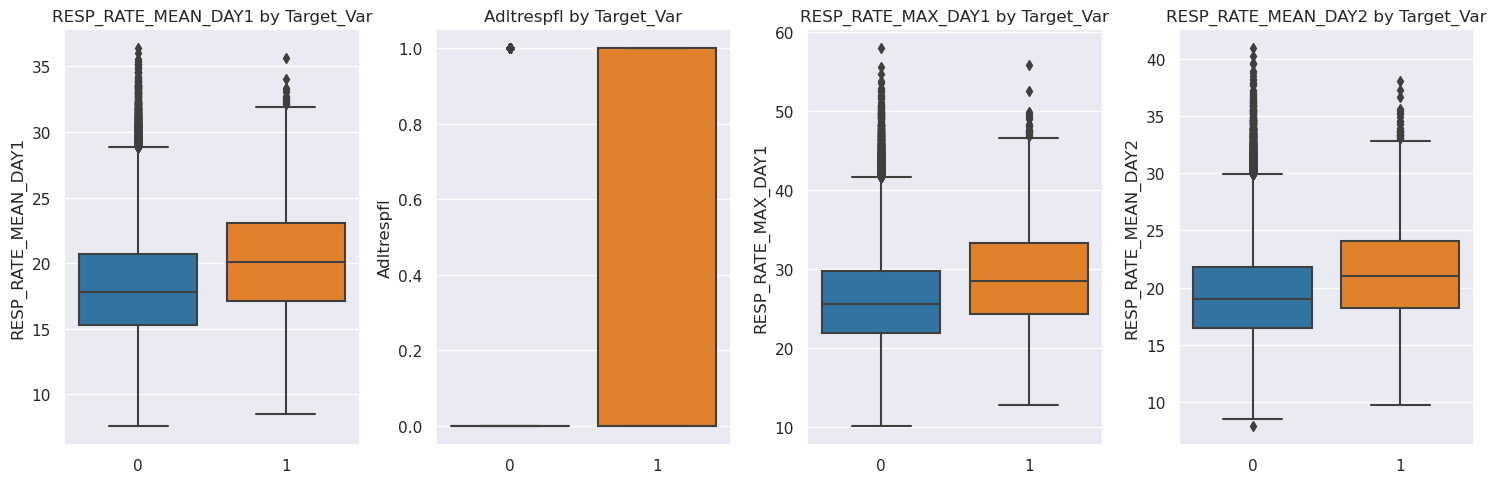

In [83]:
plt.figure(figsize=(15, 5))
top_4_correlations = top_correlations.head(4)
for i, feature in enumerate(top_4_correlations.index):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=x_df[feature], x=ys)
    plt.title(f'{feature} by Target_Var')
    plt.tight_layout()
plt.show()


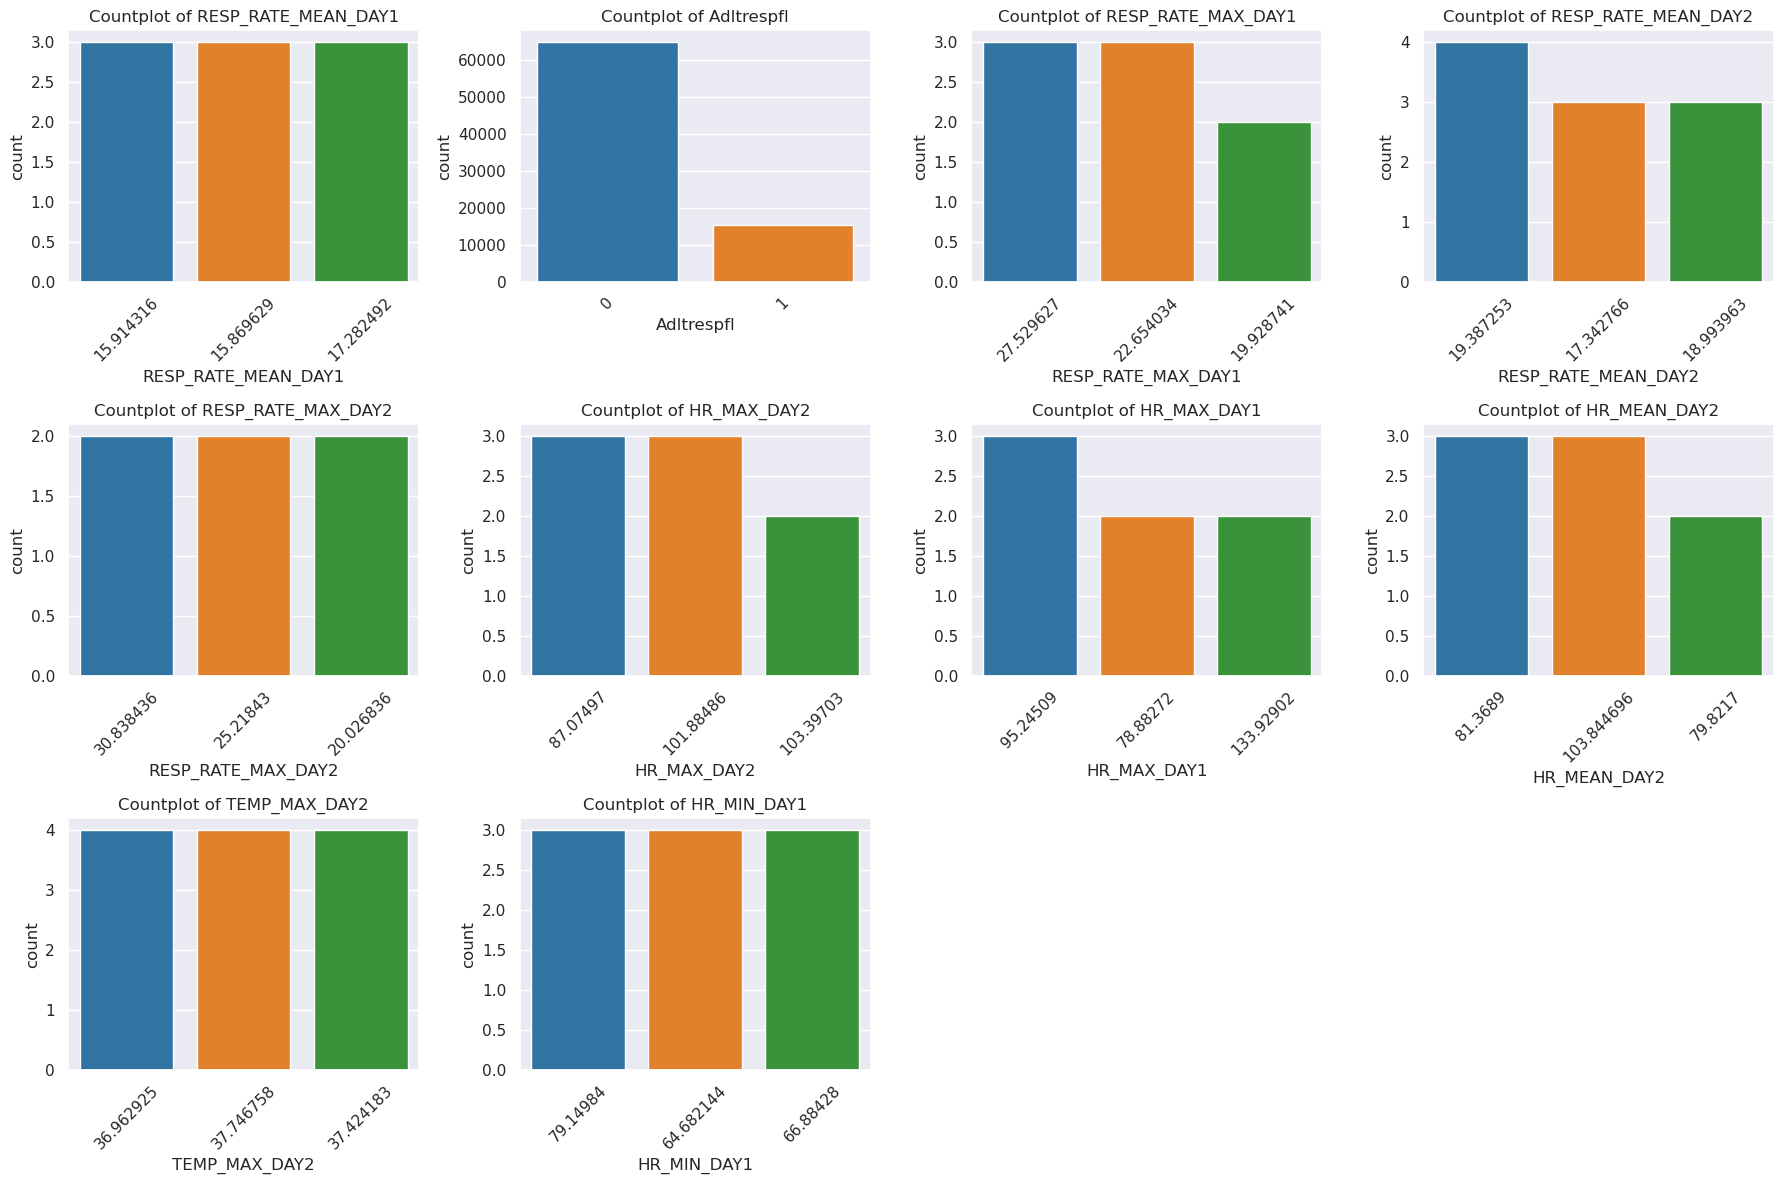

In [84]:
plt.figure(figsize=(18, 12))
for i, col in enumerate(top_correlations.index[:10]):  # Utiliser les 10 variables catégorielles les plus corrélées
    plt.subplot(3, 4, i+1)  # Afficher jusqu'à 10 graphiques dans une disposition 3x4
    top_categories = x_df[col].value_counts().nlargest(3)  # Sélectionner les 3 catégories les plus fréquentes
    sns.countplot(x=col, data=x_df, order=top_categories.index)  # Utiliser l'ordre des catégories sélectionnées
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



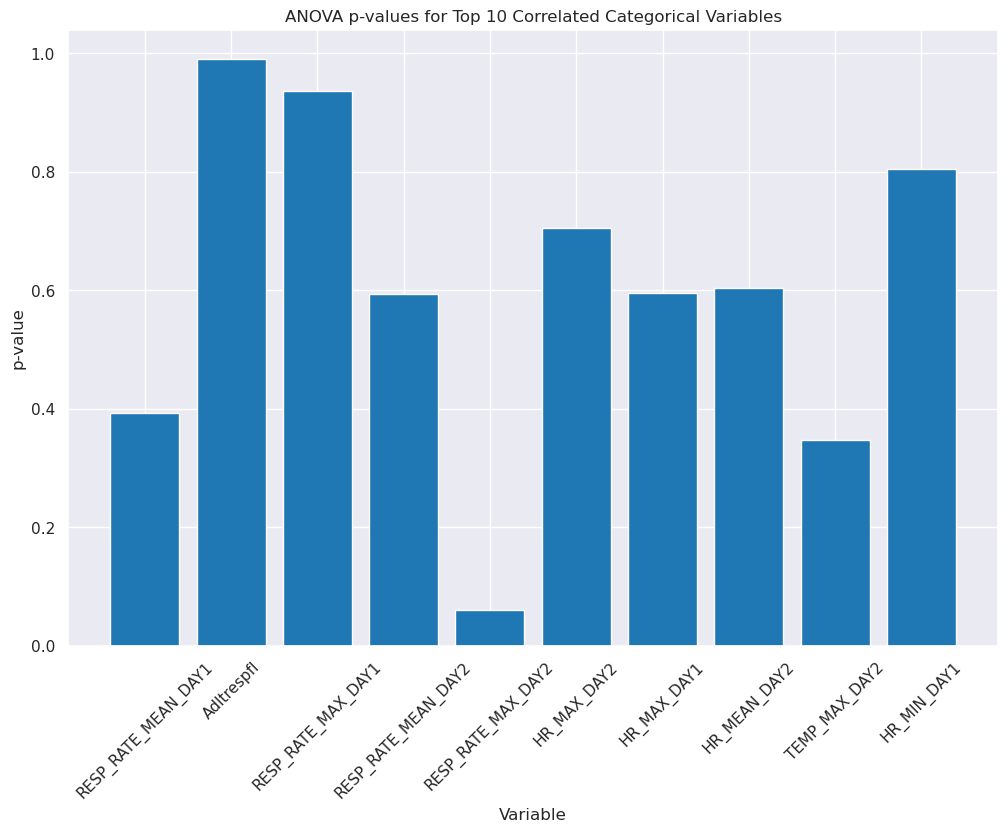

In [85]:
p_values = {}
for col in top_correlations.index[:10]:  # Utiliser les 10 variables catégorielles les plus corrélées
    groups = x_df.groupby(col).apply(lambda x: x.index.tolist())  # Utilisation de lambda pour éviter l'erreur
    p_value = f_oneway(*groups.values)[1]
    p_values[col] = p_value

# Création du graphique à barres pour les valeurs de p
plt.figure(figsize=(12, 8))
plt.bar(p_values.keys(), p_values.values())
plt.xlabel('Variable')
plt.ylabel('p-value')
plt.title('ANOVA p-values for Top 10 Correlated Categorical Variables')
plt.xticks(rotation=45)
plt.show()


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information.

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [86]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [87]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [88]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [89]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [90]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [91]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [92]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

In [93]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object', name='RELIGION')
RELIGION
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: count, dtype: int64


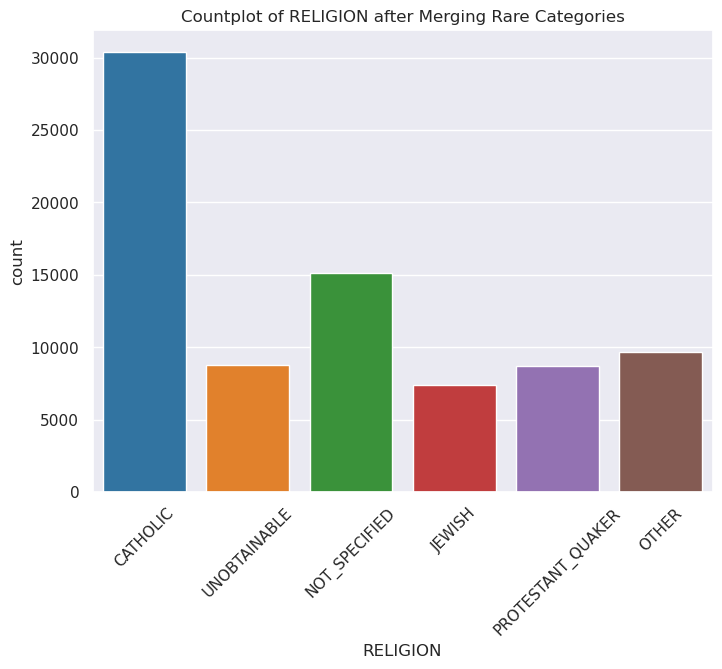

In [94]:
plt.figure(figsize=(8, 6))
sns.countplot(x='RELIGION', data=x_df)
plt.title('Countplot of RELIGION after Merging Rare Categories')
plt.xticks(rotation=45)
plt.show()


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [95]:
merge_rare_categories([x_df, x_test_df], col="ETHNICITY", keep_n=4)
print(x_test_df["ETHNICITY"].value_counts())

Index(['WHITE', 'UNKNOWN/NOT_SPECIFIED', 'BLACK/AFRICAN_AMERICAN', 'OTHER'], dtype='object', name='ETHNICITY')
ETHNICITY
WHITE                     14930
OTHER                      3053
UNKNOWN/NOT_SPECIFIED      1088
BLACK/AFRICAN_AMERICAN      930
Name: count, dtype: int64


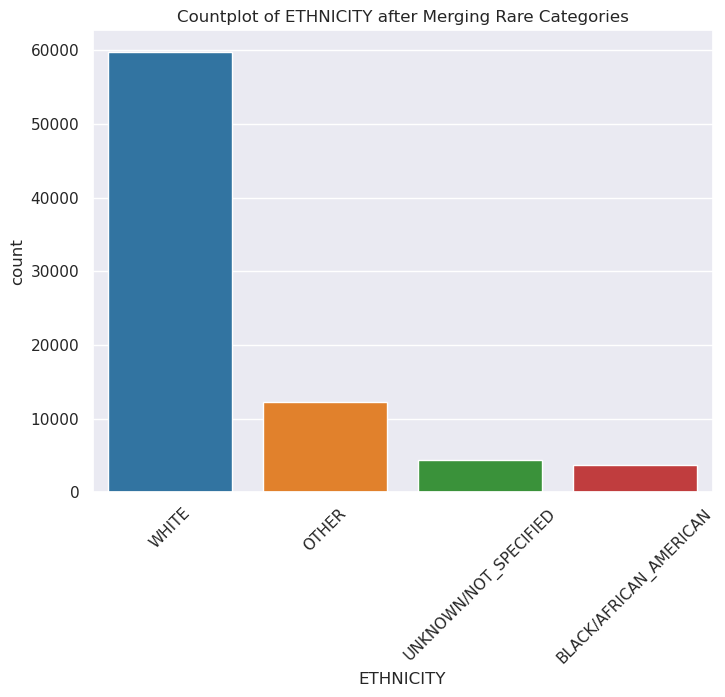

In [96]:
plt.figure(figsize=(8, 6))
sns.countplot(x='ETHNICITY', data=x_df)
plt.title('Countplot of ETHNICITY after Merging Rare Categories')
plt.xticks(rotation=45)
plt.show()


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [97]:
def label_encode(df, other_df, only_binary=False):
    """
    Select categorical variables and encode them in integers.
    """
    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [98]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [99]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [100]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [101]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [102]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,3,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [103]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1h_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1h_df = x_all_1h_df.iloc[: len(x_df)].copy()
x_test_1h_df = x_all_1h_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 337) (20001, 337)
(79999, 426) (20001, 426)


#### Suppression des variables à valeur unique (constantes)

In [104]:
const_cols = {col for col in x_1h_df if len(x_1h_df[col].unique()) == 1}
len(const_cols)

173

In [105]:
x_1h_df.drop(const_cols, axis="columns", inplace=True)
x_test_1h_df.drop(const_cols, axis="columns", inplace=True)

print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 253) (20001, 253)


### Création de l'ensemble de validation

In [106]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_1h_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1h_df

In [107]:
x_valid

,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,...,MARITAL_STATUS_WIDOWED,ETHNICITY_BLACK/AFRICAN_AMERICAN,ETHNICITY_OTHER,ETHNICITY_UNKNOWN/NOT_SPECIFIED,ETHNICITY_WHITE,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
72731,1,76,82.9,84.4,93.4,80.1,124,102,44.4,63.1,...,False,False,False,False,True,False,False,True,False,False
9125,1,51,60.3,87.4,72.6,109,162,131,49,114,...,False,False,False,False,True,False,True,False,False,False
71610,0,74,71.8,113,84.6,87.7,149,118,37.2,101,...,False,False,False,False,True,False,False,False,True,False
15141,0,27,75.8,115,94.3,80,146,109,48.9,89.3,...,False,False,False,False,True,False,False,True,False,False
52827,1,26,96.1,142,114,80.1,154,118,38,88,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63696,1,62,69.5,111,86.9,120,172,143,61,84.5,...,False,False,True,False,False,False,False,False,True,False
72326,1,67,88.1,103,93.8,100,134,116,34.4,76.5,...,False,False,False,False,True,True,False,False,False,False
28206,0,77,76.3,126,99.1,118,136,136,44.4,70.9,...,True,True,False,False,False,False,False,True,False,False
21006,1,58,50.2,65.4,64.4,73.8,148,107,39.2,99.9,...,False,False,False,False,True,False,False,False,True,False


In [108]:
x_1h_df

,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,...,MARITAL_STATUS_WIDOWED,ETHNICITY_BLACK/AFRICAN_AMERICAN,ETHNICITY_OTHER,ETHNICITY_UNKNOWN/NOT_SPECIFIED,ETHNICITY_WHITE,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,0,21,57.2,109,70.8,79.8,120,94.4,26.9,68.9,...,False,False,False,False,True,False,False,False,True,False
1,1,39,79.3,121,96.9,94,139,114,38.6,74.3,...,False,False,False,False,True,True,False,False,False,False
2,1,40,118,175,141,123,144,135,67.8,83.3,...,True,False,True,False,False,False,False,True,False,False
3,1,75,83.8,89.2,86.1,111,145,128,61.1,75.2,...,False,False,False,False,True,True,False,False,False,False
4,0,55,60.9,106,80.6,87.6,128,99.1,42.7,64,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0,76,56,97.9,79.7,77.5,120,102,26.7,49.7,...,False,False,False,False,True,False,True,False,False,False
79995,0,38,55.1,86,67.6,83.1,175,119,40.4,79.4,...,False,False,False,False,True,False,False,False,False,True
79996,0,90,74.3,91.3,91.4,95.9,139,131,52.7,85.1,...,False,False,False,False,True,False,False,False,True,False
79997,1,57,79.3,129,98.7,108,142,132,57.1,77.4,...,False,True,False,False,False,False,False,False,False,True


### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

In [109]:
scaler = StandardScaler()

# Normaliser les données avec StandardScaler
x_train_normalized = scaler.fit_transform(x_train)

# Créer un DataFrame à partir des données normalisées avec des noms de colonnes génériques
num_columns = x_train.shape[1]  # Nombre de colonnes dans x_train
generic_columns = [f"col_{i}" for i in range(num_columns)]  # Noms de colonnes génériques
x_train = pd.DataFrame(x_train_normalized)

In [110]:
scaler = StandardScaler()

# Normaliser les données avec StandardScaler
x_valid_normalized = scaler.fit_transform(x_valid)

# Créer un DataFrame à partir des données normalisées avec des noms de colonnes génériques
num_columns = x_valid.shape[1]  # Nombre de colonnes dans x_train
generic_columns = [f"col_{i}" for i in range(num_columns)]  # Noms de colonnes génériques
x_valid = pd.DataFrame(x_valid_normalized)

In [111]:
scaler = StandardScaler()

# Normaliser les données avec StandardScaler
x_normalized = scaler.fit_transform(x_1h_df)

# Créer un DataFrame à partir des données normalisées avec des noms de colonnes génériques
num_columns = x_1h_df.shape[1]  # Nombre de colonnes dans x_train
generic_columns = [f"col_{i}" for i in range(num_columns)]  # Noms de colonnes génériques
x_1h_df = pd.DataFrame(x_normalized)

In [112]:
x_valid

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,0.845,0.734,0.763,-1.02,0.448,-0.856,-1.11,-1.09,-0.0774,-1.13,...,-0.355,-0.222,-0.42,-0.234,0.576,-0.416,-0.517,1.37,-0.433,-0.4
1,0.845,-0.644,-0.776,-0.858,-0.892,0.878,0.657,0.684,0.359,1.92,...,-0.355,-0.222,-0.42,-0.234,0.576,-0.416,1.93,-0.728,-0.433,-0.4
2,-1.18,0.624,0.00693,0.552,-0.119,-0.402,0.05,-0.0703,-0.765,1.17,...,-0.355,-0.222,-0.42,-0.234,0.576,-0.416,-0.517,-0.728,2.31,-0.4
3,-1.18,-1.97,0.282,0.641,0.511,-0.859,-0.083,-0.614,0.346,0.445,...,-0.355,-0.222,-0.42,-0.234,0.576,-0.416,-0.517,1.37,-0.433,-0.4
4,0.845,-2.02,1.66,2.1,1.8,-0.854,0.305,-0.0876,-0.683,0.365,...,-0.355,-0.222,-0.42,-0.234,0.576,-0.416,-0.517,-0.728,2.31,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.845,-0.0379,-0.149,0.414,0.0284,1.51,1.1,1.41,1.49,0.155,...,-0.355,-0.222,2.38,-0.234,-1.74,-0.416,-0.517,-0.728,2.31,-0.4
23996,0.845,0.238,1.12,0.0097,0.475,0.328,-0.629,-0.199,-1.03,-0.328,...,-0.355,-0.222,-0.42,-0.234,0.576,2.41,-0.517,-0.728,-0.433,-0.4
23997,-1.18,0.789,0.313,1.23,0.818,1.39,-0.534,0.986,-0.0811,-0.666,...,2.81,4.51,-0.42,-0.234,-1.74,-0.416,-0.517,1.37,-0.433,-0.4
23998,0.845,-0.258,-1.47,-2.05,-1.42,-1.23,0.0269,-0.731,-0.573,1.08,...,-0.355,-0.222,-0.42,-0.234,0.576,-0.416,-0.517,-0.728,2.31,-0.4


In [113]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,-1.17,-0.0356,2.12,1.88,2.24,-1.58,-1.18,-1.39,-0.412,-1.23,...,-0.368,-0.22,-0.426,-0.242,0.586,-0.415,-0.515,1.37,-0.438,-0.395
1,0.853,-0.0905,-0.616,-1.47,-1.32,-0.595,-1.22,-0.85,-0.805,-1.55,...,-0.368,-0.22,-0.426,-0.242,0.586,-0.415,1.94,-0.73,-0.438,-0.395
2,0.853,-1.41,0.445,0.264,0.624,1.91,0.928,0.976,1.69,0.849,...,-0.368,-0.22,2.35,-0.242,-1.71,-0.415,1.94,-0.73,-0.438,-0.395
3,0.853,0.0741,-0.153,-0.47,-0.165,0.295,1.31,0.224,0.0129,0.56,...,-0.368,-0.22,-0.426,-0.242,0.586,-0.415,-0.515,1.37,-0.438,-0.395
4,-1.17,-1.68,1.94,1.27,2,-1.24,-1.4,-1.31,-0.334,-0.854,...,-0.368,-0.22,-0.426,-0.242,0.586,-0.415,-0.515,1.37,-0.438,-0.395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55994,0.853,1.28,0.572,0.97,0.878,-1.28,0.0826,-0.614,-0.034,0.205,...,-0.368,-0.22,2.35,-0.242,-1.71,-0.415,-0.515,1.37,-0.438,-0.395
55995,0.853,0.0741,0.615,-0.775,-0.0955,-0.159,-1.18,-0.591,-0.343,-1.34,...,-0.368,-0.22,-0.426,-0.242,0.586,-0.415,-0.515,-0.73,2.28,-0.395
55996,-1.17,0.788,0.0571,0.625,-0.229,-2.06,0.167,-0.841,0.209,-0.285,...,-0.368,-0.22,-0.426,-0.242,0.586,-0.415,1.94,-0.73,-0.438,-0.395
55997,0.853,1.28,0.23,0.731,0.307,-2.57,-0.62,-1.59,-0.604,0.859,...,-0.368,-0.22,-0.426,4.14,-1.71,2.41,-0.515,-0.73,-0.438,-0.395


<span style="color:red">
    Répondre ci-dessous
</span>

In [114]:


# Appliquer l'ACP
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

# Créer un DataFrame pour les deux premières composantes principales
pca_df = pd.DataFrame(data=x_train_pca, columns=['PC1', 'PC2'])

# Ajouter la variable cible (y_train) au DataFrame pour la visualisation
pca_df['Target'] = y_train.values

# Afficher les deux premières lignes du DataFrame
print(pca_df.head(2))


    PC1   PC2  Target
0  -2.4  2.23       0
1 -4.43 -1.32       0


Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

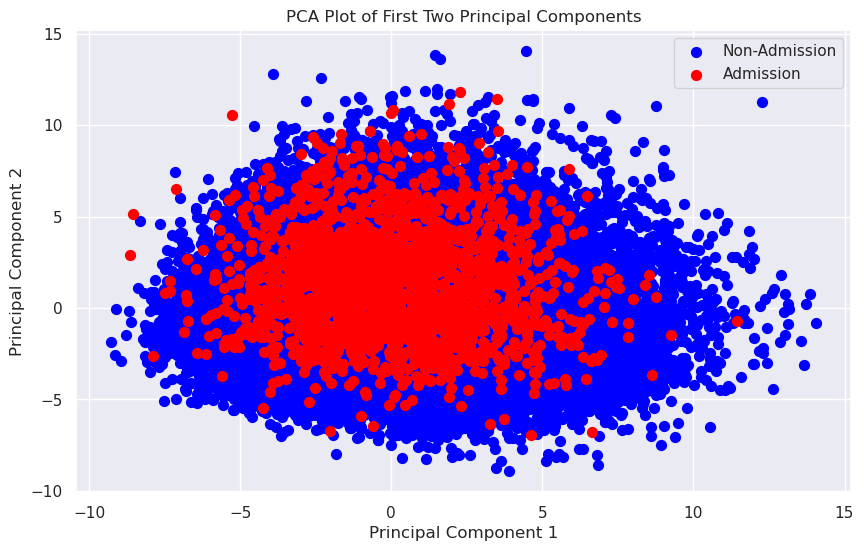

In [115]:
plt.figure(figsize=(10, 6))
targets = [0, 1]  # Valeurs uniques de la variable cible
colors = ['b', 'r']  # Couleurs pour chaque classe

for target, color in zip(targets, colors):
    indices_to_keep = pca_df['Target'] == target
    plt.scatter(pca_df.loc[indices_to_keep, 'PC1'], pca_df.loc[indices_to_keep, 'PC2'], c=color, s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(['Non-Admission', 'Admission'])
plt.title('PCA Plot of First Two Principal Components')
plt.grid(True)
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [116]:
SCORINGS = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [117]:
model1_rf = RandomForestClassifier(n_estimators=100)
model1_rf.fit(x_train, y_train)
y_pred_model1_rf = model1_rf.predict(x_valid)
score_model1_rf = balanced_accuracy_score(y_valid, y_pred_model1_rf)
print("RandomForest(100) : Balanced Accuracy = " + str(score_model1_rf))

model2_rf = RandomForestClassifier(n_estimators=200)
model2_rf.fit(x_train, y_train)
y_pred_model2_rf = model2_rf.predict(x_valid)
score_model2_rf = balanced_accuracy_score(y_valid, y_pred_model2_rf)
print("RandomForest(200) : Balanced Accuracy = " + str(score_model2_rf))

model3_rf = RandomForestClassifier(n_estimators=10)
model3_rf.fit(x_train, y_train)
y_pred_model3_rf = model3_rf.predict(x_valid)
score_model3_rf = balanced_accuracy_score(y_valid, y_pred_model3_rf)
print("RandomForest(10) : Balanced Accuracy = " + str(score_model3_rf))

RandomForest(100) : Balanced Accuracy = 0.5
RandomForest(200) : Balanced Accuracy = 0.5
RandomForest(10) : Balanced Accuracy = 0.5010839550415579


In [118]:
model4_rf = RandomForestClassifier(n_estimators=1)
model4_rf.fit(x_train, y_train)
y_pred_model4_rf = model4_rf.predict(x_valid)
score_model4_rf = balanced_accuracy_score(y_valid, y_pred_model4_rf)
print("RandomForest(1) : Balanced Accuracy = " + str(score_model4_rf))

RandomForest(1) : Balanced Accuracy = 0.5175888539769729


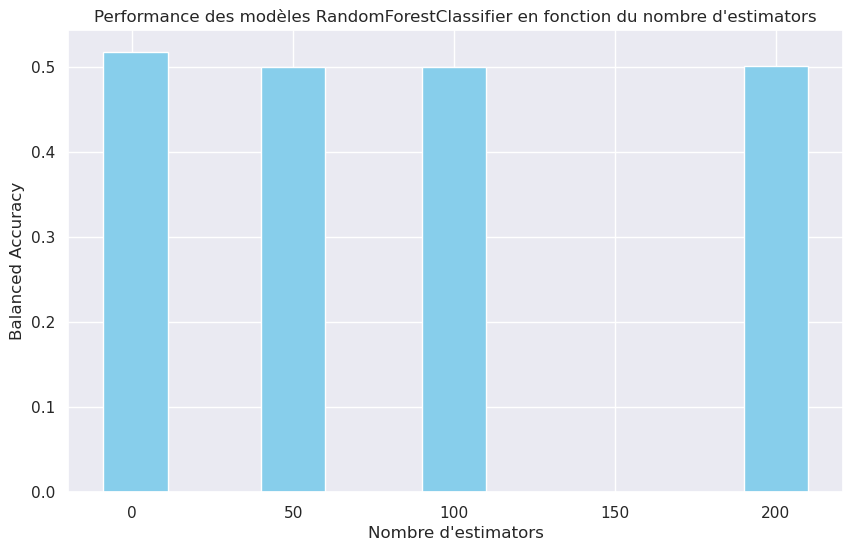

In [119]:
# Nombre d'estimateurs pour chaque modèle RandomForestClassifier
n_estimators = [100,50, 200, 1]

# Scores de précision équilibrée correspondants pour chaque modèle
scores = [score_model1_rf, score_model2_rf, score_model3_rf,score_model4_rf]

# Largeur des barres
bar_width = 20

# Création du graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(n_estimators, scores, color='skyblue', width=bar_width)

# Ajout de titres et de labels
plt.title('Performance des modèles RandomForestClassifier en fonction du nombre d\'estimators')
plt.xlabel('Nombre d\'estimators')
plt.ylabel('Balanced Accuracy')

# Affichage du graphique
plt.show()


Linear Regression (max_iter=1): Balanced Accuracy = 0.5069400448608715
Linear Regression (max_iter=2000): Balanced Accuracy = 0.522974381691223
Linear Regression (max_iter=5000): Balanced Accuracy = 0.522974381691223


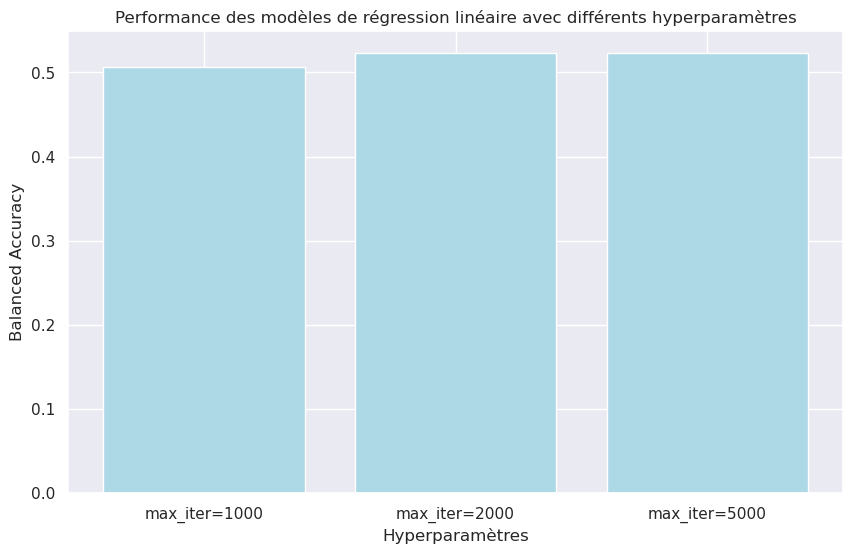

In [120]:
warnings.filterwarnings("ignore")

# Modèle de régression linéaire avec max_iter=1
model1_lr = LogisticRegression(max_iter=1)
model1_lr.fit(x_train, y_train)
y_pred = model1_lr.predict(x_valid)
score_model1_lr = balanced_accuracy_score(y_valid, y_pred)
print("Linear Regression (max_iter=1): Balanced Accuracy = " + str(score_model1_lr))

# Modèle de régression linéaire avec max_iter=2000
model2_lr = LogisticRegression(max_iter=2000)
model2_lr.fit(x_train, y_train)
y_pred = model2_lr.predict(x_valid)
score_model2_lr = balanced_accuracy_score(y_valid, y_pred)
print("Linear Regression (max_iter=2000): Balanced Accuracy = " + str(score_model2_lr))

# Modèle de régression linéaire avec max_iter=5000
model3_lr = LogisticRegression(max_iter=5000)
model3_lr.fit(x_train, y_train)
y_pred = model3_lr.predict(x_valid)
score_model3_lr = balanced_accuracy_score(y_valid, y_pred)
print("Linear Regression (max_iter=5000): Balanced Accuracy = " + str(score_model3_lr))

# Hyperparamètres pour chaque modèle LogisticRegression
hyperparams = ['max_iter=1000', 'max_iter=2000', 'max_iter=5000']

# Scores de précision équilibrée correspondants pour chaque modèle
scores = [score_model1_lr, score_model2_lr, score_model3_lr]
bar_width = 20

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(hyperparams, scores, color='lightblue')

# Ajout de titres et de labels
plt.title('Performance des modèles de régression linéaire avec différents hyperparamètres')
plt.xlabel('Hyperparamètres')
plt.ylabel('Balanced Accuracy')

# Affichage du graphique
plt.show()


XGBoost (n_estimators=100): Balanced Accuracy = 0.5126574979445071
XGBoost (n_estimators=200): Balanced Accuracy = 0.5127222619875105
XGBoost (n_estimators=300): Balanced Accuracy = 0.5138278050434028


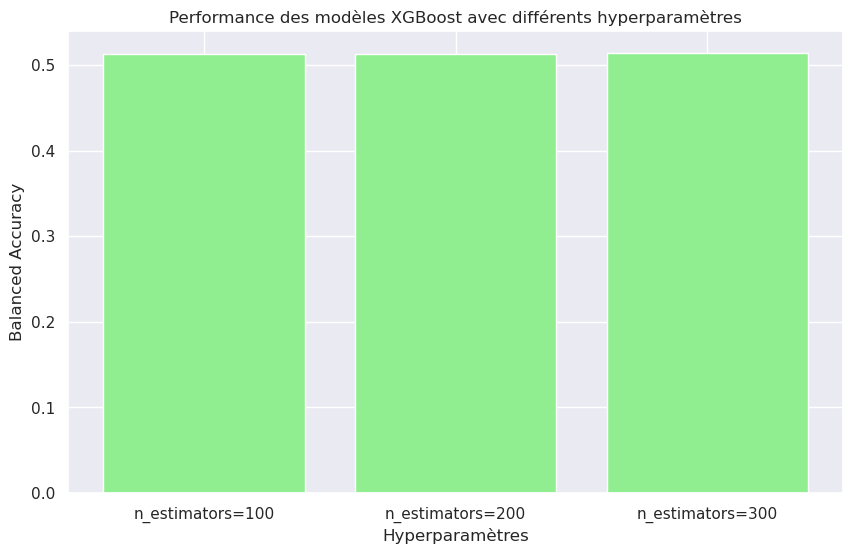

In [121]:
# Modèle XGBoost avec n_estimators=100
model1_xgb = XGBClassifier(n_estimators=100)
model1_xgb.fit(x_train, y_train)
y_pred = model1_xgb.predict(x_valid)
score_model1_xgb = balanced_accuracy_score(y_valid, y_pred)
print("XGBoost (n_estimators=100): Balanced Accuracy = " + str(score_model1_xgb))

# Modèle XGBoost avec n_estimators=200
model2_xgb = XGBClassifier(n_estimators=200)
model2_xgb.fit(x_train, y_train)
y_pred = model2_xgb.predict(x_valid)
score_model2_xgb = balanced_accuracy_score(y_valid, y_pred)
print("XGBoost (n_estimators=200): Balanced Accuracy = " + str(score_model2_xgb))

# Modèle XGBoost avec n_estimators=2000
model3_xgb = XGBClassifier(n_estimators=300)
model3_xgb.fit(x_train, y_train)
y_pred = model3_xgb.predict(x_valid)
score_model3_xgb = balanced_accuracy_score(y_valid, y_pred)
print("XGBoost (n_estimators=300): Balanced Accuracy = " + str(score_model3_xgb))

# Hyperparamètres pour chaque modèle XGBoost
hyperparams = ['n_estimators=100', 'n_estimators=200', 'n_estimators=300']

# Scores de précision équilibrée correspondants pour chaque modèle
scores = [score_model1_xgb, score_model2_xgb, score_model3_xgb]
bar_width = 20

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(hyperparams, scores, color='lightgreen')

# Ajout de titres et de labels
plt.title('Performance des modèles XGBoost avec différents hyperparamètres')
plt.xlabel('Hyperparamètres')
plt.ylabel('Balanced Accuracy')

# Affichage du graphique
plt.show()


Alpha = 0.0001, Balanced Accuracy = 0.5765120139744183
Alpha = 0.001, Balanced Accuracy = 0.5878958190731933
Alpha = 0.01, Balanced Accuracy = 0.5829549427006755


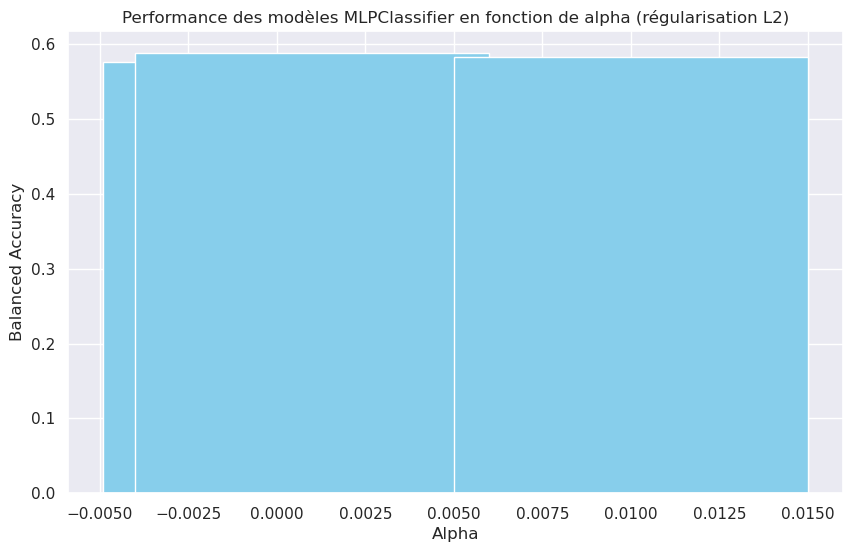

In [122]:
# Définition des valeurs pour le paramètre alpha (régularisation L2)
alphas = [0.0001, 0.001, 0.01]

# Scores de précision équilibrée correspondants pour chaque modèle
scores = []

# Entraînement et évaluation des modèles pour différentes valeurs de alpha
for alpha in alphas:
    # Création du modèle MLPClassifier avec la valeur actuelle de alpha
    model = MLPClassifier(alpha=alpha, random_state=2)
    
    # Entraînement du modèle
    model.fit(x_train, y_train)
    
    # Prédiction sur les données de validation
    y_pred = model.predict(x_valid)
    
    # Calcul de la balanced accuracy
    score = balanced_accuracy_score(y_valid, y_pred)
    
    # Ajout du score à la liste des scores
    scores.append(score)
    
    print(f"Alpha = {alpha}, Balanced Accuracy = {score}")

# Création du graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(alphas, scores, color='skyblue', width=0.01)

# Ajout de titres et de labels
plt.title('Performance des modèles MLPClassifier en fonction de alpha (régularisation L2)')
plt.xlabel('Alpha')
plt.ylabel('Balanced Accuracy')

# Affichage du graphique
plt.show()


## 6. Évaluations

### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

<span style="color:red">
    Répondre ci-dessous
</span>

* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous.
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

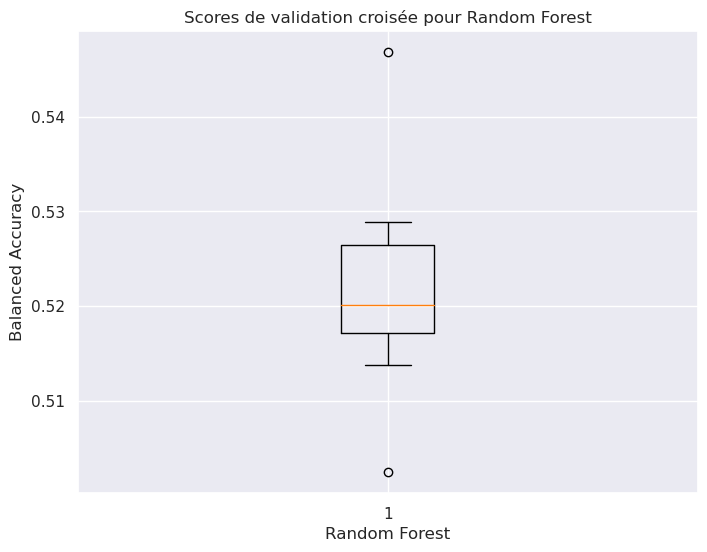

In [123]:
# Définir le modèle Random Forest 
model_rf = RandomForestClassifier(n_estimators=1)

# Effectuer la validation croisée avec 10 plis
scores_rf = cross_val_score(model_rf, x_train, y_train, cv=10, scoring='balanced_accuracy')

# Afficher le boxplot des scores de validation croisée
plt.figure(figsize=(8, 6))
plt.boxplot(scores_rf)
plt.title('Scores de validation croisée pour Random Forest')
plt.xlabel('Random Forest')
plt.ylabel('Balanced Accuracy')
plt.show()


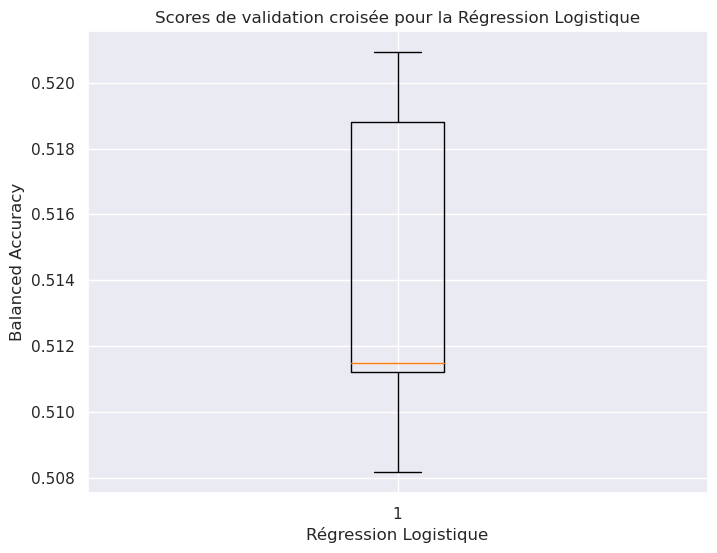

In [124]:
warnings.filterwarnings("ignore")

# Définir le modèle de régression logistique
model_lr = LogisticRegression(max_iter=1)

# Effectuer la validation croisée avec 10 plis
scores_lr = cross_val_score(model_lr, x_train, y_train, cv=10, scoring='balanced_accuracy')

# Afficher le boxplot des scores de validation croisée
plt.figure(figsize=(8, 6))
plt.boxplot(scores_lr)
plt.title('Scores de validation croisée pour la Régression Logistique')
plt.xlabel('Régression Logistique')
plt.ylabel('Balanced Accuracy')
plt.show()

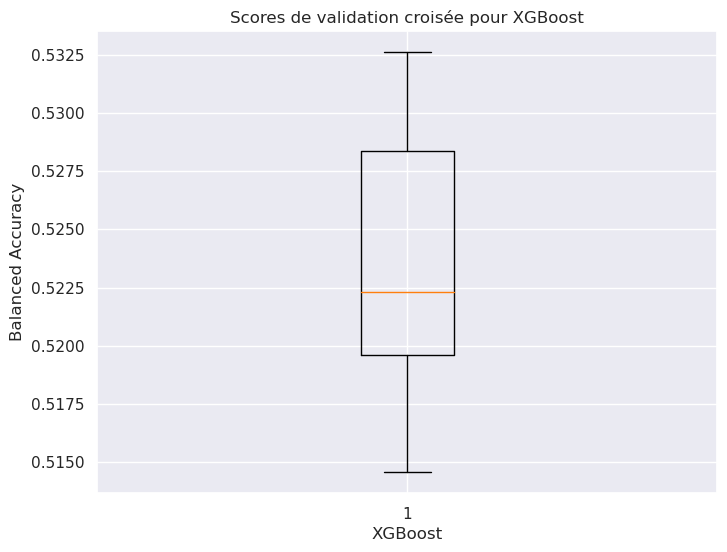

In [125]:
# Définir le modèle XGBoost
model_xgb = XGBClassifier(n_estimators=300)

# Effectuer la validation croisée avec 10 plis
scores_xgb = cross_val_score(model_xgb, x_train, y_train, cv=10, scoring='balanced_accuracy')

# Afficher le boxplot des scores de validation croisée
plt.figure(figsize=(8, 6))
plt.boxplot(scores_xgb)
plt.title('Scores de validation croisée pour XGBoost')
plt.xlabel('XGBoost')
plt.ylabel('Balanced Accuracy')
plt.show()

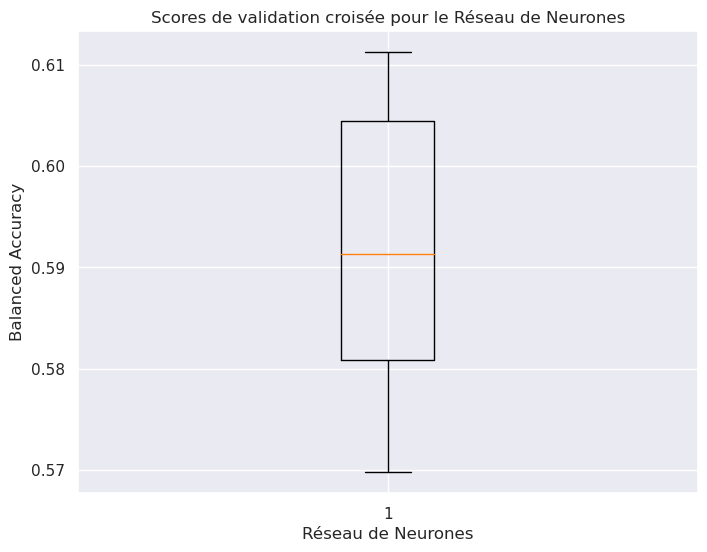

In [126]:
# Définir le modèle de réseau de neurones
model_nn = MLPClassifier()

# Effectuer la validation croisée avec 10 plis
scores_nn = cross_val_score(model_nn, x_train, y_train, cv=10, scoring='balanced_accuracy')

# Afficher le boxplot des scores de validation croisée
plt.figure(figsize=(8, 6))
plt.boxplot(scores_nn)
plt.title('Scores de validation croisée pour le Réseau de Neurones')
plt.xlabel('Réseau de Neurones')
plt.ylabel('Balanced Accuracy')
plt.show()


<span style="color:red">
    Répondre ci-dessous
</span>

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

In [127]:
# Entraîner le modèle de forêt aléatoire avec les meilleurs hyperparamètres
best_rf_model = RandomForestClassifier(n_estimators=1)
best_rf_model.fit(x_train, y_train)

# Prédire les probabilités sur l'ensemble de validation
y_prob_rf = best_rf_model.predict_proba(x_valid)[:, 1]

# Calculer l'AUC
auc_rf = roc_auc_score(y_valid, y_prob_rf)
print("AUC pour Random Forest:", auc_rf)

AUC pour Random Forest: 0.5167855431217627


In [128]:
warnings.filterwarnings("ignore")

# Entraîner le modèle de régression logistique avec les meilleurs hyperparamètres
best_lr_model = LogisticRegression(max_iter=1)
best_lr_model.fit(x_train, y_train)

# Prédire les probabilités sur l'ensemble de validation
y_prob_lr = best_lr_model.predict_proba(x_valid)[:, 1]

# Calculer l'AUC
auc_lr = roc_auc_score(y_valid, y_prob_lr)
print("AUC pour la Régression Logistique:", auc_lr)

AUC pour la Régression Logistique: 0.7365911799761621


In [129]:
# Définir et entraîner le modèle XGBoost avec 2000 estimateurs
model_xgb = XGBClassifier(n_estimators=300)
model_xgb.fit(x_train, y_train)

# Prédire les probabilités sur l'ensemble de validation
y_prob_xgb = model_xgb.predict_proba(x_valid)[:, 1]

# Calculer l'AUC
auc_xgb = roc_auc_score(y_valid, y_prob_xgb)
print("AUC pour XGBoost avec 2000 estimateurs:", auc_xgb)

AUC pour XGBoost avec 2000 estimateurs: 0.7719209560644541


In [130]:
model_mlp = MLPClassifier(alpha=0.001)
model_mlp.fit(x_train, y_train)

# Prédire les probabilités sur l'ensemble de validation
y_prob_mlp = model_mlp.predict_proba(x_valid)[:, 1]

# Calculer l'AUC
auc_mlp = roc_auc_score(y_valid, y_prob_mlp)
print("AUC pour MLPClassifier avec alpha=0.001:", auc_mlp)

AUC pour MLPClassifier avec alpha=0.001: 0.7737498905804161


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

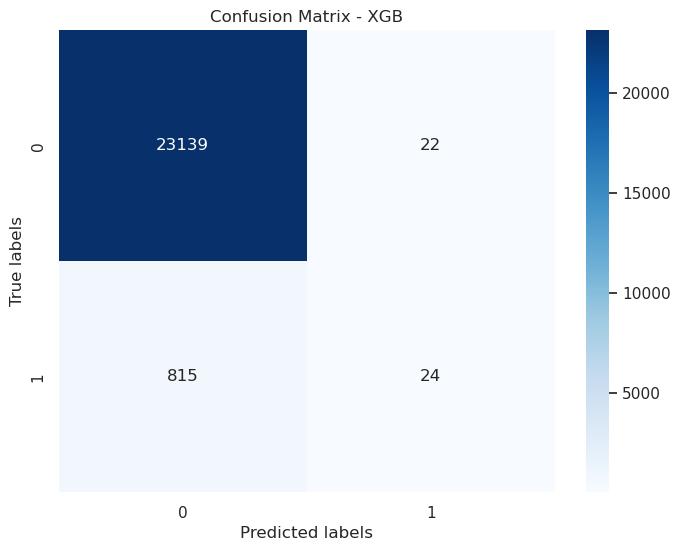

AUC pour XGB: 0.7719209560644541


In [131]:
# Calculer la matrice de confusion
y_pred_xgb = model_xgb.predict(x_valid)
conf_matrix = confusion_matrix(y_valid, y_pred_xgb)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - XGB')
plt.show()

# Afficher la valeur de l'AUC
print("AUC pour XGB:", auc_xgb)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

In [132]:
# Création du pipeline avec data augmentation utilisant SMOTE et Gradient Boosting comme modèle
pipe_gb_smote = imblearn.pipeline.Pipeline([
    ("scale", preprocessing.StandardScaler()),
    ("resample", imblearn.over_sampling.SMOTE()),
    ("model", LogisticRegression(C=300, max_iter=300)),
])

# Entraînement du modèle sur les données augmentées avec SMOTE
pipe_gb_smote.fit(x_train, y_train)

# Prédiction sur l'ensemble de validation
y_pred_gb_smote = pipe_gb_smote.predict(x_valid)

# Calcul du score de précision équilibrée avec SMOTE
score_gb_smote = balanced_accuracy_score(y_valid, y_pred_gb_smote)
precision_gb_smote = precision_score(y_valid, y_pred_gb_smote)
recall_gb_smote = recall_score(y_valid, y_pred_gb_smote)

print("Meilleur score possible avec data augmentation (LogisticRegression et SMOTE) :", score_gb_smote)

Meilleur score possible avec data augmentation (LogisticRegression et SMOTE) : 0.7497358105635532


### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions
Le meilleur résultat obtenu est 0.76 pour la logistic regression pour l'instant .
Processing:

On a testé des différents modèles sur des paramètres différents pour la PCA et on a choisi le modèle avec l'accuracy score le plus élevé parmis toutes les paramètres de PCA testées. Les deux modèles avec meilleurs accuracy score sont la logistics regression et le GradientBoostClassifier et pour l'instant le modele SVM est en cours en execution celui ci est trés trés lent pour l'execution.

Ayant trouvé nos modèles, on a testé plusieurs paramètres manuellement pour le random forest.

Au debut on a utilisé Standard Scalar pour standariser les données puis

pour la normalisation des données on a utiliser le PCA avec le n_components idéal (trouvé auparavant) pour réduire les dimensions du dataset.
On a utilisé plusieurs modeles pour booster notre score tels que XGBOOST , GRADIENTBOOSTCLASSIFIER , RandomForestClassifier , LogisticRegression et actuellement on essaye le modéle SVM mais qui est trés lent à l'execution malheureusement .
La durée d’entrainement des modèles varie entre une minute et une dizaine de minute voir plus .
Si on aurait eu plus de temps , on aurait fait varier d'autres hyperparamétres pour differents modeles et on aurait eu encore plus de temps pour executer certains modéles qui sont trés lourds à l'execution.

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ?

Le suréchantillonnage est une technique utilisé pour ajuster la distribution des données entre les classes en augmentant les données de la classe minoritaire sous representée à fin d'arriver a un ratio classe minoritaire/classe majoritaire convenable pour l'apprentisage.

* En quoi pourrait-il être utile dans ce problème ?

Dans ce problème la classe minoritaire sous représentée est la classe des patients qui meurent, si on augmente les échantillons de patients qui meurent on peut fit notre modèle avec un dataset équilibrée sur lequel les algorithmes d'apprentissage sont plus effectifs.

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1h_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [133]:
predictions = pipe_gb_smote.predict(x_test_1h_df) 

In [134]:
# VARS: x_test_df, x_test_fact_df, x_test_1h_df, x_test_1h_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2024-05-04T15-56-15.zip


---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />